In [ ]:
#Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Torchvision_model Download
#Deeplabv3_resnet101 기반 Image segmentation model _Overall classes:21 (human label==15)
import torch
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)

model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

#Image Segmentation

In [ ]:
from PIL import Image
from torchvision import transforms

filename='/content/drive/MyDrive/2912436941397721496.jpg' #사진 경로
input_image = Image.open(filename) #PIL 활용 이미지오픈
input_image = input_image.convert("RGB") #Convert RGB
preprocess = transforms.Compose([
    transforms.Resize((700,1050)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]) #preprocess for tensor

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)
check = torch.where(output_predictions == 15, 1,0) #클래스 15가 사람이므로, 사람을 제외한 모든 클래스 예측에는 0을, 사람으로 예측한 부분에는 1을 준 grayscale mask 생성

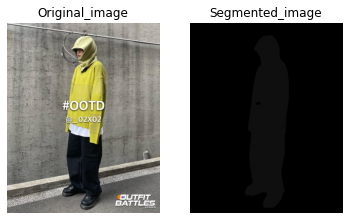

In [ ]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 20 - 1, 2 ** 20 - 1, 2 ** 20 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(check.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt

fig = plt.figure()
rows = 1
cols = 2

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(input_image)
ax1.set_title('Original_image')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(r)
ax2.set_title('Segmented_image')
ax2.axis("off")
 
plt.show()


# plt.show()

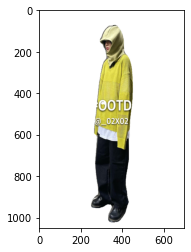

In [ ]:
#Original image와 Segmented image를 결합하여 무신사 코디와 같은 이미지로 변환

import numpy as np

def apply_mask(image, mask):
  image=np.array(image.resize((700,1050))) #resizing the input image
  mask=np.array(mask.resize((700,1050)))
  mask=np.stack((mask,)*3, axis=-1) #Expand the dimension of mask array since the mask is 'grayscale'
  result=image*mask #Multiplication
  result[mask==0]=255
  return result

result=apply_mask(input_image, r)
plt.imshow(result)

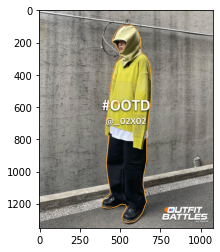

In [ ]:
import cv2
import numpy as np
import random

# Draw Contours
contours, hierarchy = cv2.findContours(np.array(r), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) #Contour 좌표와 트리 형태의 hierachy 반환
c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
canvas=cv2.drawContours(np.array(input_image), contours, -1, c,3)
    
plt.imshow(canvas)

In [ ]:
#image segmentation function on the input image
#위에 기술된 코드들을 function화 / 추가 주석 x
def img_seg(path):
      """
      input:
       path: 파일 경로 / dtype=str
      output:
       result: masked input image, which looks like the 'musinsa' clothing photos
      """


      input_image = Image.open(path)
      input_image = input_image.convert("RGB")
      preprocess = transforms.Compose([
      transforms.Resize((700,1050)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
      input_tensor = preprocess(input_image)
      input_batch = input_tensor.unsqueeze(0)

      if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

      with torch.no_grad():
       output = model(input_batch)['out'][0]

      output_predictions = output.argmax(0)
      check = torch.where(output_predictions == 15, 1,0)
      palette = torch.tensor([2 ** 20 - 1, 2 ** 20 - 1, 2 ** 20 - 1])
      colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
      colors = (colors % 255).numpy().astype("uint8")

      # plot the semantic segmentation predictions of 21 classes in each color
      r = Image.fromarray(check.byte().cpu().numpy()).resize(input_image.size)
      r.putpalette(colors)

      result=apply_mask(input_image, r)
      result=Image.fromarray(result)
      return result



#Dataframe Preprocessing

In [ ]:
#데이터 프레임 불러오기
import pandas as pd

df=pd.read_csv('/content/drive/MyDrive/KUIAI-해커톤/musinsa.csv')

In [ ]:
#Dataframe Preprocessing
#Tag로 카테고리 생성

import ast

tag_list=['#아메리칸 캐주얼','#캐주얼','#시크','#댄디','#포멀','#걸리시','#골프','#레트로','#로맨틱','#스포츠','#스트릿']
df['category']=None

for i in range(df.shape[0]):
  x=ast.literal_eval(df['tag'][i])
  for tag in tag_list:
    if tag in x:
      df['category'][i]=tag

In [ ]:
df['category'].value_counts()

#캐주얼         6020
#댄디          1806
#스트릿         1794
#걸리시         1772
#포멀          1195
#로맨틱         1005
#시크           654
#골프           580
#스포츠          515
#아메리칸 캐주얼     158
#레트로          153
Name: category, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16394 entries, 0 to 16393
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_url   16394 non-null  object
 1   tag       16394 non-null  object
 2   text      16394 non-null  object
 3   category  15652 non-null  object
dtypes: object(4)
memory usage: 512.4+ KB


#Cosine similarity

In [ ]:
#코사인 유사도 계산 함수
import torch

def cosine_sim(img1, img2):
  """
  input: 
  """
  tensor=transforms.ToTensor()
  img1=torch.flatten(tensor(img1));img2=torch.flatten(tensor(img2))
  sim=torch.nn.CosineSimilarity(dim=0)
  output=sim(img1, img2)
  return output.item()


In [ ]:
def musinsa_sim(img,df, category):

  """
  Input: 
   img: list of images, images which are converted as torch are stored in a list
   df: pandas dataframe with category & tag at each row
   category: one of '#아메리칸 캐주얼','#캐주얼','#시크','#댄디','#포멀','#걸리시','#골프','#레트로','#로맨틱','#스포츠','#스트릿'
  Output:
   list of list of tuples_(similarity value, idx of image)
  """
  sim_address=[]

  for image in imgs:
    sim_list=[(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)] #유사도 튜플 리스트
    name='#'+category
    idx=df.index[df['category'] == name].tolist() #해당 카테고리에 해당되는 코디 인덱스 리스트

    for i in idx:
     try: 
      input_image = Image.open('/content/drive/MyDrive/KUIAI-해커톤/data/musinsa_'+str(i)+'.jpg')
      input_image = input_image.convert("RGB").resize((700,1050))
      output=cosine_sim(image, input_image) #코사인 유사도 계산
      print(output)
      sim_list.sort(key=lambda x:x[0],reverse=True) #역정렬
      if output>sim_list[-1][0]:
        sim_list[-1]=(output,i)
        
      
     except:
       None
    sim_address.append(sim_list)

  return sim_address

In [ ]:
#Experiment
#'댄디'로 사진을 넣었을 때 다른 댄디 코디 사진과의 유사도 계산
imgs=[img_seg("/content/drive/MyDrive/KUIAI-해커톤/카리나1.jpg"),img_seg("/content/drive/MyDrive/KUIAI-해커톤/카리나2.jpg"),img_seg("/content/drive/MyDrive/KUIAI-해커톤/카리나3.jpg")]
address=musinsa_sim(imgs,df,'걸리시')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
0.95882248878479
0.9621607065200806
0.9548187255859375
0.9639663696289062
0.9487095475196838
0.9550884962081909
0.9633063673973083
0.9532051086425781
0.9622756242752075
0.9607802033424377
0.9580506682395935
0.9421401023864746
0.9610489010810852
0.945012629032135
0.9448296427726746
0.9595635533332825
0.9454782009124756
0.9556509852409363
0.9506127834320068
0.9500979781150818
0.9641047120094299
0.9494353532791138
0.9674355983734131
0.9525552988052368
0.9425576329231262
0.9587118625640869
0.9495425224304199
0.9395914673805237
0.9607657194137573
0.9589176177978516
0.9624242186546326
0.960318386554718
0.9465930461883545
0.9656493663787842
0.9600570797920227
0.9512910842895508
0.9585395455360413
0.9602198600769043
0.9482722878456116
0.9530289173126221
0.9330632090568542
0.9553027153015137
0.9525716304779053
0.9603962898254395
0.9383584260940552
0.9478479027748108
0.9508618116378784
0.9616968631744385
0.965478777885437
0.9633088111877441
0.9629068374633789


In [ ]:
#Final Result
address

[[(0.9685046076774597, 1570),
  (0.9683423638343811, 916),
  (0.9681882858276367, 11752),
  (0.9676226377487183, 6804),
  (0.9674572348594666, 8383),
  (0.9674355983734131, 2910),
  (0.9671482443809509, 6466)],
 [(0.970233142375946, 7988),
  (0.9686515927314758, 3330),
  (0.967694103717804, 6123),
  (0.9670047163963318, 5239),
  (0.9669193029403687, 10354),
  (0.9668545126914978, 5712),
  (0.9668132066726685, 6121)],
 [(0.9436636567115784, 16380),
  (0.9401638507843018, 2460),
  (0.9400948882102966, 1824),
  (0.9398335814476013, 10488),
  (0.9391803741455078, 2085),
  (0.9388213753700256, 10628),
  (0.943595826625824, 16391)]]

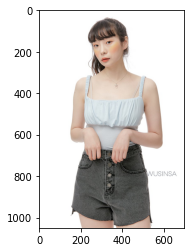

In [ ]:
plt.imshow(Image.open('/content/drive/MyDrive/KUIAI-해커톤/data/musinsa_'+str(address[2][4][1])+'.jpg'))  

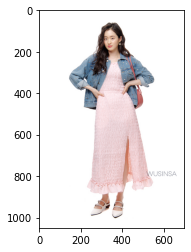

In [ ]:
plt.imshow(Image.open('/content/drive/MyDrive/KUIAI-해커톤/data/musinsa_'+str(address[0][0][1])+'.jpg'))  

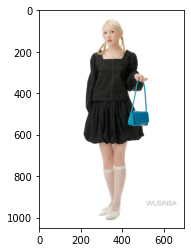

In [ ]:
plt.imshow(Image.open('/content/drive/MyDrive/KUIAI-해커톤/data/musinsa_'+str(address[1][0][1])+'.jpg'))  

#Historgram Similarity

In [ ]:
import cv2
import numpy as np
import matplotlib.pylab as plt

#cv2 library를 활용하여 Histogrma similarity 계산

def hist_sim(imgs,method):
  hists = []
  for img in imgs:
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #hsv로 변환
    hists=[]
    for i in range(3): #B/G/R에 대하여 색상별로 histogram 계산
     a = cv2.calcHist([hsv], [i], None, [512], [0,512]) #bins=512의 histogram으로 변환
     hists.append(a)

    hist=cv2.merge([hists[0],hists[1],hists[2]]) #B/G/R Histogram Merge
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_L1)  #L1_Normalization
    hists.append(hist)

  
  query = hists[0]
  ret = cv2.compareHist(query, hists[1], method) #Histogram 유사도 계산
  
  return ret
  

In [ ]:
def hist_sim_all(imgs,df,category,method=cv2.HISTCMP_CORREL):

  """
  Input: 
   img: list of images, images which are converted as torch are stored in a list
   df: pandas dataframe with category & tag at each row
   category: one of '#아메리칸 캐주얼','#캐주얼','#시크','#댄디','#포멀','#걸리시','#골프','#레트로','#로맨틱','#스포츠','#스트릿'
   method = same with the 'method', input variable of cv2.comparehist variable 
  Output:
   list of list of tuples_(similarity value, idx of image)
  """

  sim_address=[]

  for image in imgs:
    sim_list=[(0,0),(0,0),(0,0),(0,0),(0,0),(0,0),(0,0)]
    name='#'+category
    idx=df.index[df['category'] == name].tolist()

    for i in idx:
     try: 
      input_image = Image.open('/content/drive/MyDrive/KUIAI-해커톤/data/musinsa_'+str(i)+'.jpg')
      input_image = input_image.convert("RGB").resize((700,1050))
      output=hist_sim([image,np.array(input_image)],method) #histogram similarity 계산
      print(output)
      sim_list.sort(key=lambda x:x[0],reverse=True)
      if output>sim_list[-1][0]:
        sim_list[-1]=(output,i)
        
      
     except:
       None
    sim_address.append(sim_list)

  return sim_address

In [ ]:
ad=hist_sim_all([result],df,'스트릿')

0.9943200825782555
0.997938153622035
0.9915725818582547
0.9966736328551741
0.9913521117014066
0.9978492495875698
0.9944758132501631
0.9973934073060858
0.9967393402977902
0.9957180612599879
0.9949438115846622
0.9949672004615879
0.9940579545183258
0.99593922187149
0.9948480191750926
0.9956176521366783
0.9976672068605003
0.9958924670740766
0.9824697540567151
0.9986608170817561
0.9938264362848309
0.9949195364133351
0.9964343425586283
0.9977695906129448
0.997528120572627
0.9871688662522353
0.9941795715047296
0.9953789961013253
0.9969457253656652
0.9971348403696945
0.9958781880695322
0.9969539338199268
0.9989673392238919
0.9938980894282631
0.9982198696001607
0.9927714087156542
0.9914441529829523
0.9966336873742782
0.9971762223695253
0.9976642382596588
0.995874807324926
0.996717995724353
0.9968273933699209
0.9971894527727042
0.9958387784567225
0.996328072811834
0.9970408074267957
0.9973541110553407
0.9964382515592876
0.9974065916972503
0.9981634027607486
0.9963300204957056
0.9967272250877097


In [ ]:
ad

[[(0.9993068772044075, 8057),
  (0.9992792549245608, 4607),
  (0.9992466278803347, 3801),
  (0.9991535866533435, 1493),
  (0.9991458282264399, 13018),
  (0.99913701229227, 15505),
  (0.9991329681057027, 10800)]]

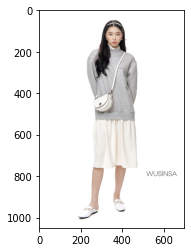

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(Image.open('/content/drive/MyDrive/KUIAI-해커톤/data/musinsa_8057.jpg'))  

#Euclidean Distance similarity

In [ ]:
def euc_sim_all(imgs,df,category):

  """
  *input & output is same with the 'musinsa_sim' which is based on Cosine Similarity
  Input: 
   img: list of images, images which are converted as torch are stored in a list
   df: pandas dataframe with category & tag at each row
   category: one of '#아메리칸 캐주얼','#캐주얼','#시크','#댄디','#포멀','#걸리시','#골프','#레트로','#로맨틱','#스포츠','#스트릿'
  Output:
   list of list of tuples_(similarity value, idx of image)
  """

  sim_address=[]

  for image in imgs:
    sim_list=[(100000,0),(100000,0),(100000,0),(100000,0),(100000,0),(100000,0),(100000,0)]
    name='#'+category
    idx=df.index[df['category'] == name].tolist()

    for i in idx[4000:]:
     try: 
      input_image = Image.open('/content/drive/MyDrive/KUIAI-해커톤/data/musinsa_'+str(i)+'.jpg')
      input_image = input_image.convert("RGB").resize((700,1050))
      output=np.linalg.norm(image - np.array(input_image)) #Calculate Euclidean Distance, using numpy.linalg.norm
      sim_list.sort(key=lambda x:x[0])
      if output<sim_list[-1][0]:
        sim_list[-1]=(output,i)
        
      
     except:
       None
    sim_address.append(sim_list)

  return sim_address

In [ ]:
euc=euc_sim_all([result],df,'캐주얼')

In [ ]:
euc

[[(80919.09390249003, 13612),
  (81464.14902888263, 12719),
  (82680.7859118429, 13810),
  (83285.81193696799, 13764),
  (83417.52103724972, 12936),
  (84068.33660778592, 13759),
  (85051.59879155712, 11605)]]

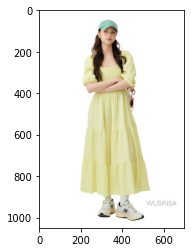

In [ ]:
plt.imshow(Image.open('/content/drive/MyDrive/KUIAI-해커톤/data/musinsa_'+str(euc[0][0][1])+'.jpg'))  